In [1]:
import random
import torch

seed = 42

torch.manual_seed(seed)
random.seed(seed)

print(torch.__version__)

print(torch.cuda.is_available())

2.7.0+cu118
True


In [2]:
%matplotlib inline

In [3]:
train_dir = './train'

In [4]:
def show_random_image(path, fig_size=(24, 12)):
        import os
        from PIL import Image 

        import matplotlib.patches as patches
        import matplotlib.pyplot as plt

        def yolo_to_bbox(yolo_detection, image_width, image_height):
            class_id, x_center, y_center, width, height = yolo_detection
            x_min = (x_center - width / 2) * image_width
            y_min = (y_center - height / 2) * image_height
            x_max = (x_center + width / 2) * image_width
            y_max = (y_center + height / 2) * image_height
            return int(x_min), int(y_min), int(x_max), int(y_max), class_id

        
        img_name = random.choice(os.listdir(f'{path}/images'))
        image = Image.open(f"{path}/images/{img_name}")

        label = img_name.split('.')[0]

        img_classes = open(
            f"{path}/labels/{label}.txt", "r", encoding="utf-8"
        ).readlines()
        img_classes = [s.split() for s in img_classes]
        fig, ax = plt.subplots(figsize=fig_size)

        yolo_labels = []

        for label in img_classes:
            img_class, *coords = label
            yolo_labels.append([img_class, *[float(i) for i in coords]])

        print(yolo_labels)

        # paint rectangles over image
        for label in yolo_labels:
            x_min, y_min, x_max, y_max, class_id = yolo_to_bbox(
                label, image.size[0], image.size[1]
            )
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="r",
                facecolor="none",
            )
            ax.add_patch(rect)

        ax.imshow(image)
        plt.show()

[['0', 0.36325, 0.685667, 0.1575, 0.074]]


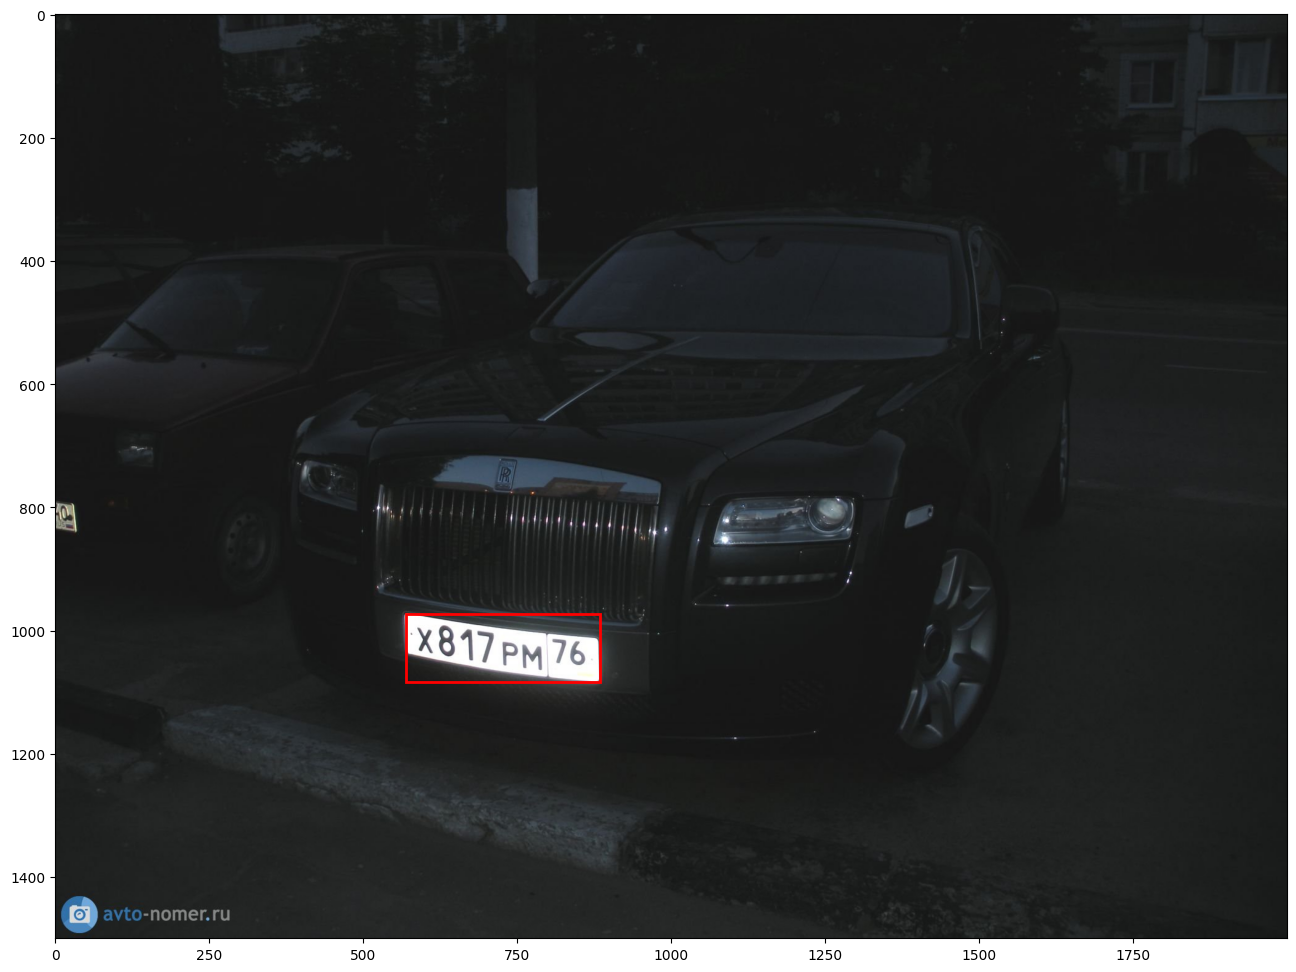

In [5]:
show_random_image(train_dir, fig_size=(24, 12))

In [6]:
from ultralytics.models.yolo.detect import DetectionTrainer

def get_yaml_config(yaml_cfg :str):
    import yaml
    with open(yaml_cfg, encoding='utf-8') as stream:
        print(stream)
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)


cfg = get_yaml_config('train.yaml')


data = 'lpr.yaml'

args = cfg['training'] 
args['data'] = data
args['project'] = 'c3k2_light_320_nwd'
args['imgsz'] = 320
args['batch'] = 16
args['lr0'] = 1e-5
args['warmup_epochs'] = 0
args['optimizer'] = 'SGD'
args['model'] = './c3k2_light/train/weights/best.pt'
print(cfg)
trainer = DetectionTrainer(overrides=args)

<_io.TextIOWrapper name='train.yaml' mode='r' encoding='utf-8'>
{'training': {'epochs': 300, 'imgsz': 320, 'batch': 16, 'degrees': 45, 'patience': 10, 'save_period': 3, 'exist_ok': True, 'deterministic': False, 'plots': True, 'single_cls': True, 'model': './c3k2_light/train/weights/best.pt', 'data': 'lpr.yaml', 'project': 'c3k2_light_320_nwd', 'lr0': 1e-05, 'warmup_epochs': 0, 'optimizer': 'SGD'}}
Ultralytics 8.3.146  Python-3.11.0 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8191MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=lpr.yaml, degrees=45, deterministic=False, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0

In [7]:
trainer.train()

WARNING no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      3972  ultralytics.nn.modules.block.C3k2            [32, 48, 1, False, 0.25]      
  3                  -1  1     20832  ultralytics.nn.modules.conv.Conv             [48, 48, 3, 2]                
  4                  -1  1      4356  ultralytics.nn.modules.block.C3k2            [48, 48, 1, False, 0.25]      
  5                  -1  1     20832  ultralytics.nn.modules.conv.Conv             [48, 48, 3, 2]                
  6                  -1  1      4704  ultralytics.nn.modules.block.C3k2            [48, 48, 1, True, 0.25]       
  7                  -1  1     20832

train: Scanning D:\projects\lpr_detect\train\labels.cache... 20505 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20505/20505 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 38.224.3 MB/s, size: 276.2 KB)


val: Scanning D:\projects\lpr_detect\val\labels.cache... 2563 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2563/2563 [00:00<?, ?it/s]


Plotting labels to c3k2_light_320_nwd\train\labels.jpg... 
optimizer: SGD(lr=1e-05, momentum=0.937) with parameter groups 76 weight(decay=0.0), 83 weight(decay=0.0005), 82 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to c3k2_light_320_nwd\train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300     0.473G     0.9202     0.5502     0.9651         16        320: 100%|██████████| 1282/1282 [02:35<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:24<00:00,  3.30it/s]

                   all       2563       2678      0.964      0.947      0.966       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300     0.672G     0.8765     0.4891      0.956         23        320: 100%|██████████| 1282/1282 [02:37<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:21<00:00,  3.72it/s]

                   all       2563       2678      0.964      0.949      0.966      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300     0.672G     0.8717     0.4821     0.9542         20        320: 100%|██████████| 1282/1282 [02:33<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:24<00:00,  3.30it/s]

                   all       2563       2678      0.965      0.949      0.966      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300     0.678G     0.8567     0.4725      0.951         20        320: 100%|██████████| 1282/1282 [02:42<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:26<00:00,  3.03it/s]

                   all       2563       2678      0.964      0.947      0.966      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300     0.678G     0.8521     0.4708     0.9499         14        320: 100%|██████████| 1282/1282 [02:36<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:23<00:00,  3.41it/s]

                   all       2563       2678      0.965      0.946      0.967      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300     0.678G     0.8467     0.4699      0.949         15        320: 100%|██████████| 1282/1282 [02:31<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:22<00:00,  3.66it/s]

                   all       2563       2678      0.963      0.944      0.966      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300     0.678G     0.8448     0.4694     0.9496         14        320: 100%|██████████| 1282/1282 [02:26<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:20<00:00,  3.88it/s]

                   all       2563       2678      0.965      0.946      0.966      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300     0.678G     0.8305     0.4626     0.9486         24        320: 100%|██████████| 1282/1282 [02:30<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:22<00:00,  3.57it/s]

                   all       2563       2678      0.965      0.946      0.966      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300     0.678G     0.8356     0.4656     0.9469         13        320: 100%|██████████| 1282/1282 [02:29<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:22<00:00,  3.63it/s]

                   all       2563       2678      0.963      0.948      0.966      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300     0.678G     0.8212     0.4642     0.9465         19        320: 100%|██████████| 1282/1282 [02:20<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:21<00:00,  3.75it/s]

                   all       2563       2678      0.964      0.948      0.966      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300     0.678G     0.8123     0.4637     0.9449         14        320: 100%|██████████| 1282/1282 [02:32<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:23<00:00,  3.45it/s]

                   all       2563       2678      0.961      0.949      0.966      0.731
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.537 hours.
Optimizer stripped from c3k2_light_320_nwd\train\weights\last.pt, 2.7MB
Optimizer stripped from c3k2_light_320_nwd\train\weights\best.pt, 2.7MB

Validating c3k2_light_320_nwd\train\weights\best.pt...
Ultralytics 8.3.146  Python-3.11.0 torch-2.7.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8191MiB)
YOLO11_speed_6 summary (fused): 91 layers, 1,229,363 parameters, 0 gradients, 4.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:26<00:00,  3.02it/s]


                   all       2563       2678      0.964      0.947      0.966       0.74
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to c3k2_light_320_nwd\train


<Axes: >

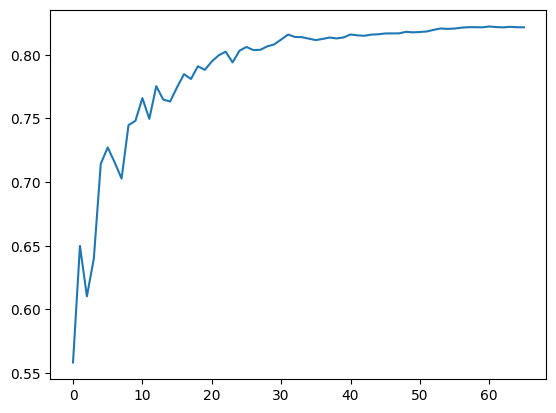

In [2]:
import pandas as pd

results = pd.read_csv('./runs/detect/train/results.csv')

results['metrics/mAP50-95(B)'].plot()



image 1/1 d:\projects\lpr_detect\test_2.jpg: 384x640 1 item, 8.9ms
Speed: 3.6ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict


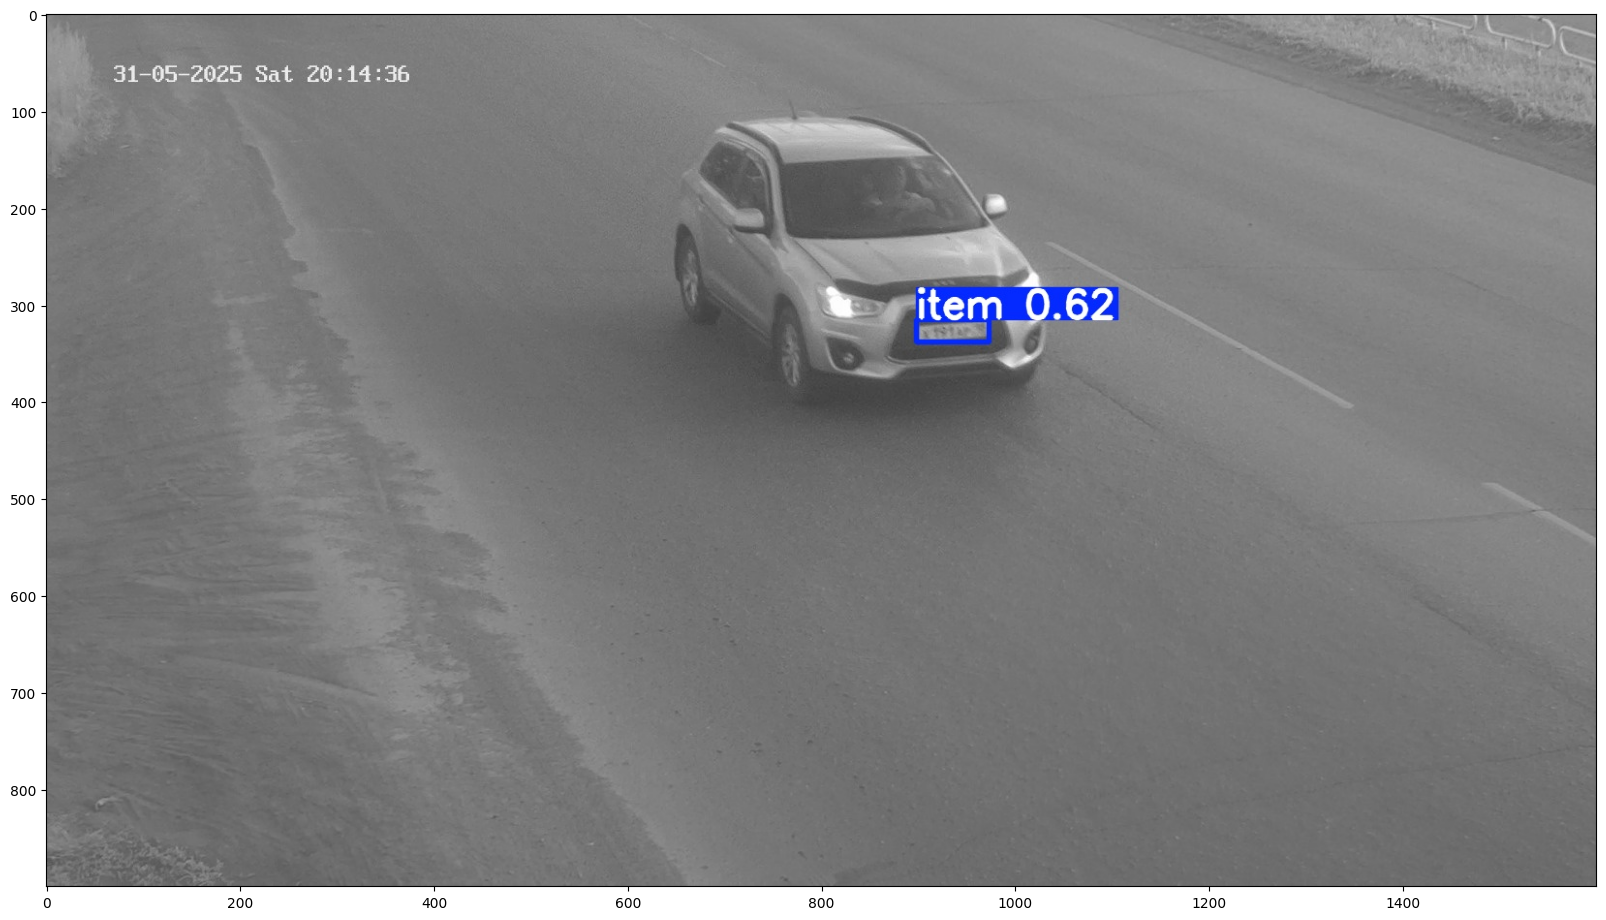

In [48]:
from ultralytics import YOLO
import random
import os
import matplotlib.pyplot as plt



model_path = f'./runs/baseline_nano/train/weights/best.pt'
images_path = './val/images'

model = YOLO(model_path)   #загружаем самую лучшую модель
model = model.eval()

# image = random.choice([i for i in os.listdir(images_path) if i.endswith('jpg')])

# results = model(f'{images_path}/{image}', save=True) 

results = model('test_2.jpg', save=True) 


dir = results[0].save_dir
image_path = os.listdir(dir)[0]

path = f"{dir}/{image_path}"

plt.figure(figsize = (20,15))
image = plt.imread(path)
imgplot = plt.imshow(image)

plt.show()
